<a href="https://colab.research.google.com/github/singhvis29/Hands_On_LLM_WR/blob/main/Ch5_Text_Clustering_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install bertopic datasets openai datamapplot

In [2]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
load_dataset("maartengr/arxiv_nlp")

DatasetDict({
    train: Dataset({
        features: ['Titles', 'Abstracts', 'Years', 'Categories'],
        num_rows: 44949
    })
})

### Text Clastering Pipeline

#### 1, Embedding Documents

In [4]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [5]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

#### 2. Reduce the dimensionality of embeddings

In [6]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### 4. Clustering the reduced embeddings

In [7]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


153

#### Inspecting the Clusters

In [8]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [9]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-7.778345727920533,
 10.878833436965943,
 -1.711702972650528,
 16.388065367937088)

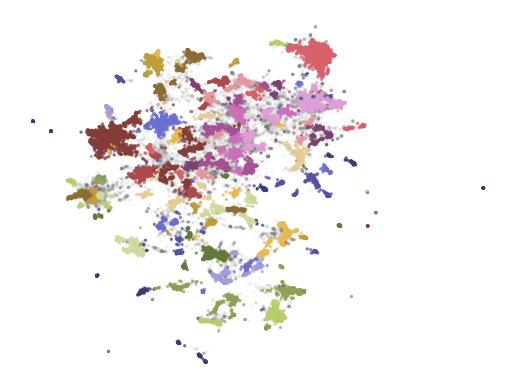

In [10]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

## Topic Modeling

### BERTopic

In [11]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-03-24 10:40:00,453 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-24 10:41:05,413 - BERTopic - Dimensionality - Completed ✓
2025-03-24 10:41:05,417 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-24 10:41:08,338 - BERTopic - Cluster - Completed ✓
2025-03-24 10:41:08,353 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-24 10:41:12,140 - BERTopic - Representation - Completed ✓


In [12]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14462                               -1_the_of_and_to   
1        0   2241                 0_question_questions_qa_answer   
2        1   2098                   1_speech_asr_recognition_end   
3        2    903               2_image_visual_multimodal_images   
4        3    887  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
148    147     54           147_counseling_mental_therapy_health   
149    148     53                     148_chatgpt_its_openai_has   
150    149     52                149_mixed_code_sentiment_mixing   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     51         151_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, for, that, language...   
1    [question, questions, qa, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, audi...   
3    [image, visual, multimodal, images, vision, mo...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
148  [counseling, mental, therapy, health, psychoth...   
149  [chatgpt, its, openai, has, it, tasks, capabil...   
150  [mixed, code, sentiment, mixing, english, anal...   
151  [diffusion, generation, autoregressive, text, ...   
152  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Cross-lingual text classification aims at t...  
1    [  Question generation (QG) attempts to solve ...  
2    [  End-to-end models have achieved impressive ...  
3    [  In this paper we propose a model to learn m...  
4    [  We present a novel divide-and-conquer metho...  
..                                                 ...  
148  [  Mental health care poses an increasingly se...  
149  [  Over the last few years, large language mod...  
150  [  In today's interconnected and multilingual ...  
151  [  Diffusion models have achieved great succes...  
152  [  While there has been significant progress t...  

[153 rows x 5 columns]

In [13]:
topic_model.get_topic(0)

[('question', 0.021262463291547223),
 ('questions', 0.015866039067984204),
 ('qa', 0.015830640927795868),
 ('answer', 0.015787698152510205),
 ('answering', 0.014859992848422435),
 ('answers', 0.00992918704536005),
 ('retrieval', 0.009497931820914705),
 ('comprehension', 0.007719047154229789),
 ('reading', 0.007175282051339653),
 ('knowledge', 0.0063049421989358)]

In [18]:
topic_model.find_topics("topic modeling")

([22, -1, 50, 38, 84],
 [0.95448655, 0.91218555, 0.9067658, 0.9051957, 0.9026561])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [15]:
topic_model.get_topic(22)

[('topic', 0.06782148231481569),
 ('topics', 0.03509097163093816),
 ('lda', 0.0162350543969945),
 ('latent', 0.013482620892138605),
 ('document', 0.01258276852968132),
 ('documents', 0.012463820004375148),
 ('modeling', 0.011571581804609226),
 ('dirichlet', 0.009901318233964887),
 ('word', 0.00852094200971816),
 ('allocation', 0.007792539607690728)]

In [16]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

22

#### Visualizations

In [19]:

# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [20]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [21]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

In [22]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()